In [1]:
import pandas as pd
import glob

def get_indicator_df(indicator):
    """
    returns rows with specific indicator
    """
    all_files = glob.glob("dataset/*.csv")

    print(len(all_files))

    #Les fichiers doivent être enregistrés au format AAAA-MM.csv dans un sous-répertoire 'train'
    dataframe = pd.DataFrame()
    temp_df = pd.DataFrame()
    list_ = []
    for f in all_files:
        df = pd.read_csv(f, sep=';')
        date = str(f.split(".")[0]).split("\\")[1]
        #eg indicator:CU/H ACT
        temp_df = df.loc[df['indicateur'] == indicator]
        temp_df['Date_mois'] = date
        list_.append(temp_df)

    dataframe = pd.concat(list_)
    dataframe = dataframe.reset_index(drop = True)

    #Convert indicator values to float and return the global dataframe 
    #print(type(dataframe["tx_atteinte_indicateur"][0]))
    dataframe["tx_atteinte_indicateur"] = [x.replace(',', '.') for x in dataframe["tx_atteinte_indicateur"].values]
    dataframe = dataframe.astype({"tx_atteinte_indicateur": float})
    print(dataframe)
    dataframe.to_csv('result.csv', index = False)
    return dataframe
dataframe = get_indicator_df('CU/H ACT')

9
      matricule             nom_prenom         compte statut  \
0        700074      BAILLEUL ISABELLE  ORANGE AUTRES    CDI   
1        700101     BAROIS MARIE-LAURE  ORANGE AUTRES    CDI   
2        700104     CHIZZOLINI PASCALE  ORANGE AUTRES    CDI   
3        700130        LESCIEUX ELODIE  ORANGE AUTRES    CDI   
4        700181  NOUIDRA MERZAK SAADIA  ORANGE AUTRES    CDI   
...         ...                    ...            ...    ...   
3128     701458       THUILLIER ALEXIS  ORANGE AUTRES    CDI   
3129     702430          THOMAS SANDRA  ORANGE AUTRES    CDI   
3130     702720           BULTEEL YVES  ORANGE AUTRES    CDI   
3131     705236         BEAUMONT DAVID  ORANGE AUTRES    CDI   
3132     706818     TOUSSAIN GUILLAUME  ORANGE AUTRES    CDI   

                 activite     typologie tx_presenteisme note_qualite h_action  \
0              ORANGE PCM  FIDELISATION     0,741071429          NaN       10   
1              ORANGE PCM  FIDELISATION     0,956043956          Na

C:\Users\Akram\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
def extract_matricule_date_indicator(dataframe):
    """
    Groupby matricule, date
    """
    #df.duplicated(subset=['matricule', 'Date'])
    print(len(dataframe['matricule'].unique()))
    grouped_df = pd.DataFrame(dataframe.groupby(["matricule",'Date_mois'], as_index = False).mean()[["matricule", "Date_mois", "tx_atteinte_indicateur"]])
    grouped_df = grouped_df.set_index('matricule')
    return grouped_df
grouped_df = extract_matricule_date_indicator(dataframe)
#grouped_df.columns

252


In [3]:
import datetime

def fix_dates_as_columns(grouped_df):
    #convert string dates to date objects
    header_dates = list(grouped_df['Date_mois'].unique())
    header_dates = sorted(header_dates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m'))
    print(header_dates)
    df_for_lstm = pd.DataFrame(index=grouped_df.index, columns=header_dates)
    for row in grouped_df.itertuples():
        df_for_lstm.at[row.Index, row.Date_mois] = row.tx_atteinte_indicateur
    df_for_lstm.drop_duplicates(inplace = True)
    df_for_lstm.to_csv('df_for_lstm.csv')
    return df_for_lstm
df_for_lstm = fix_dates_as_columns(grouped_df)
df_for_lstm

['2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05']


,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05
matricule,,,,,,,,,
100420,0.659,1.637,1.222,0,1.959,1.778,1.007,NaN,NaN
100441,0.624,0.664,0.7182,0.975,0.399,NaN,NaN,NaN,NaN
100442,0.851,2.094,0.6908,0.385,0.8665,1.408,0.9275,NaN,2.083
100443,0.651667,0.9962,0.6412,0.6788,0.968667,0.8916,0.87025,NaN,NaN
100444,0.746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
707457,0,NaN,0.6555,0.715,NaN,1.052,0.941,NaN,1.213
707464,0.663,0.456,0.541,0.302,NaN,NaN,NaN,NaN,NaN
707468,0.877,0.932,1.22,0.9835,1.1155,0.9595,1.322,NaN,1.318


In [11]:
from sklearn.model_selection import train_test_split
# Drop rows with 2020-05 values equal to null
df_for_lstm = df_for_lstm[df_for_lstm['2020-05'].notnull()]
print(len(df_for_lstm))
# y: Target column
y = df_for_lstm['2020-05']
# X: Time serie that our model will learn from (train and test)
X = df_for_lstm.drop(['2020-05'], axis=1)
# Replace NaN values in X by -1
X.fillna(-1, inplace=True)
# Convert X and y to float values
X=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)
print(X)
# Split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


117
[[ 0.851       2.094       0.6908      0.385       0.8665      1.408
   0.9275     -1.        ]
 [ 0.669       0.8675      0.898       0.797       0.955       0.7443333
   1.162       1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.          0.312     ]
 [ 0.853       0.869       1.1866666   0.954       1.1875      1.0565
   1.3545     -1.        ]
 [ 1.039       0.568       1.053       1.274       1.4475      1.1285
   0.988      -1.        ]
 [-1.          0.          1.0016667   1.088       1.219       1.09
   1.22       -1.        ]
 [-1.         -1.         -1.         -1.         -1.          1.152
   1.099       1.        ]
 [-1.         -1.         -1.         -1.         -1.          1.575
   1.512      -1.        ]
 [-1.         -1.         -1.         -1.         -1.          1.09
   1.373      -1.        ]
 [ 1.12475     1.1093333   1.061       1.04425     1.1106666   1.258
   1.4495     -1.        ]
 [ 1.247       1.0585      0.9735  

# LSTM Neural network

(78, 8)
(78, 8, 1)
Epoch 1/50
39/39 - 0s - loss: 0.5768 - mse: 0.5768 - mae: 0.6104
Epoch 2/50
39/39 - 0s - loss: 0.2583 - mse: 0.2583 - mae: 0.3162
Epoch 3/50
39/39 - 0s - loss: 0.1863 - mse: 0.1863 - mae: 0.2659
Epoch 4/50
39/39 - 0s - loss: 0.1606 - mse: 0.1606 - mae: 0.2580
Epoch 5/50
39/39 - 0s - loss: 0.1617 - mse: 0.1617 - mae: 0.2484
Epoch 6/50
39/39 - 0s - loss: 0.1603 - mse: 0.1603 - mae: 0.2558
Epoch 7/50
39/39 - 0s - loss: 0.1554 - mse: 0.1554 - mae: 0.2493
Epoch 8/50
39/39 - 0s - loss: 0.1541 - mse: 0.1541 - mae: 0.2349
Epoch 9/50
39/39 - 0s - loss: 0.1505 - mse: 0.1505 - mae: 0.2470
Epoch 10/50
39/39 - 0s - loss: 0.1613 - mse: 0.1613 - mae: 0.2485
Epoch 11/50
39/39 - 0s - loss: 0.1542 - mse: 0.1542 - mae: 0.2660
Epoch 12/50
39/39 - 0s - loss: 0.1551 - mse: 0.1551 - mae: 0.2557
Epoch 13/50
39/39 - 0s - loss: 0.1516 - mse: 0.1516 - mae: 0.2595
Epoch 14/50
39/39 - 0s - loss: 0.1448 - mse: 0.1448 - mae: 0.2404
Epoch 15/50
39/39 - 0s - loss: 0.1565 - mse: 0.1565 - mae: 0.2627


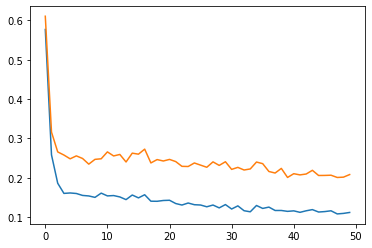

[0.13368000090122223, 0.13368000090122223, 0.2798161506652832]
[1.72      0.915     0.967     1.3385    1.453     1.32      0.786
 0.907     0.406     1.31      1.2905    0.        1.167     0.9735
 1.071     2.083     1.654     0.736     0.863     1.462     1.544
 1.463     0.857     1.056     1.27      1.079     2.1113334 1.159
 1.306     0.8606667 1.48      1.351     1.31      0.698     1.442
 1.19      1.0903333 0.863     1.068    ] [[1.1014252 ]
 [1.1490681 ]
 [1.123189  ]
 [1.0818682 ]
 [1.1561284 ]
 [1.1124732 ]
 [1.1181722 ]
 [1.0958128 ]
 [1.244719  ]
 [1.0459318 ]
 [1.1522882 ]
 [0.01127135]
 [1.1594214 ]
 [1.171835  ]
 [1.2714651 ]
 [1.1427767 ]
 [1.1374924 ]
 [1.1864204 ]
 [1.0993576 ]
 [1.1333911 ]
 [1.1318321 ]
 [1.0974374 ]
 [0.75863147]
 [1.1576004 ]
 [1.1567407 ]
 [1.0975418 ]
 [1.1572535 ]
 [1.1358778 ]
 [1.2357867 ]
 [1.1300452 ]
 [1.1447921 ]
 [1.1095548 ]
 [1.1324191 ]
 [1.2503011 ]
 [1.1053307 ]
 [1.1202028 ]
 [1.1543012 ]
 [1.1145597 ]
 [1.1043913 ]]


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from matplotlib import pyplot

print(X_train.shape)
#Reshape input data
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

#y_train = y_train.to_numpy().reshape((-1,1, 1))

print(X_train.shape)
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(8, 1), return_sequences=True)) # Prends en entrée un seul exemple d'apprentissage de dimension (1, 8) à la fois
model.add(LSTM(50))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])

# fit model
history = model.fit(X_train, y_train, epochs=50, batch_size=2, verbose=2)

# predict
yhat = model.predict(X_test)

# plot metrics (training error evolution)
pyplot.plot(history.history['mse'])
pyplot.plot(history.history['mae'])
pyplot.show()

# Error MSE and MAE
score = model.evaluate(X_test, y_test, verbose=0) # loss: mean_squared_error, metrics: mse, mae
print(score)
print(y_test, yhat)
#il faut plus de données